# Flower recognition model using CNN

### Importing necessary libraries

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

import os
import random
import warnings
warnings.filterwarnings('ignore')

### Loading training and test data along with target values

In [5]:
# Creating training data as a numpy array

X_train_daisy = [cv.imread('flowers/training_set/daisy/'+i) for i in os.listdir('flowers/training_set/daisy')]

X_train_dandelion = [cv.imread('flowers/training_set/dandelion/'+i) for i in os.listdir('flowers/training_set/dandelion')]

X_train_rose = [cv.imread('flowers/training_set/rose/'+i) for i in os.listdir('flowers/training_set/rose')]

X_train_sunflower = [cv.imread('flowers/training_set/sunflower/'+i) for i in os.listdir('flowers/training_set/sunflower')]

X_train_tulip = [cv.imread('flowers/training_set/tulip/'+i) for i in os.listdir('flowers/training_set/tulip')]

# Encoding target labels 
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
encoder = LabelEncoder()
categories = encoder.fit(categories)

In [6]:
print(X_train_daisy)

[array([[[228, 220, 213],
        [220, 212, 212],
        [215, 207, 207],
        ...,
        [ 14,   9,  11],
        [ 11,   6,   7],
        [ 14,  10,   9]],

       [[222, 215, 206],
        [228, 221, 218],
        [226, 218, 218],
        ...,
        [ 12,   7,   8],
        [ 12,   7,   8],
        [ 11,   7,   6]],

       [[234, 226, 219],
        [225, 218, 215],
        [228, 220, 220],
        ...,
        [ 12,   7,   8],
        [ 15,  11,  10],
        [ 10,   6,   5]],

       ...,

       [[232, 229, 221],
        [228, 224, 219],
        [226, 219, 216],
        ...,
        [160, 172, 178],
        [160, 170, 177],
        [150, 158, 165]],

       [[235, 230, 227],
        [232, 227, 226],
        [239, 231, 232],
        ...,
        [162, 168, 181],
        [164, 168, 179],
        [151, 156, 165]],

       [[236, 229, 226],
        [243, 236, 233],
        [237, 231, 224],
        ...,
        [157, 173, 186],
        [156, 163, 178],
        [150, 147, 162]

In [7]:
# Creating target labels for training data

Y_train_daisy = np.array(['daisy' for i in range(len(X_train_daisy))])
Y_train_dandelion = np.array(['dandelion' for i in range(len(X_train_dandelion))])
Y_train_rose = np.array(['rose' for i in range(len(X_train_rose))])
Y_train_sunflower = np.array(['sunflower' for i in range(len(X_train_sunflower))])
Y_train_tulip = np.array(['tulip' for i in range(len(X_train_tulip))])

# Combining all the target labels
Y_train_classes = np.concatenate((Y_train_daisy, Y_train_dandelion, Y_train_rose, Y_train_sunflower, Y_train_tulip), axis=0)

# Encoding target labels
Y_train = encoder.transform(Y_train_classes)
print(Y_train)

[0 0 0 ... 4 4 4]


In [8]:
# Combining all the training data
X_train = np.concatenate((X_train_daisy, X_train_dandelion, X_train_rose, X_train_sunflower, X_train_tulip), axis=0)

# Converting BGR to RGB for all the images in X_train
X_train = [cv.cvtColor(i, cv.COLOR_BGR2RGB) for i in X_train]

# Resizing the images in X_train to 224x224
X_train = [cv.resize(i, (224, 224), interpolation=cv.INTER_CUBIC) for i in X_train]

X_train = np.array(X_train)
print(X_train.shape)
print(X_train)

(3614, 224, 224, 3)
[[[[213 216 224]
   [207 213 219]
   [208 210 218]
   ...
   [  6   7  11]
   [  9   8  12]
   [  7   7  12]]

  [[215 220 228]
   [219 223 230]
   [217 216 224]
   ...
   [ 11  12  16]
   [ 15  13  18]
   [  8   9  13]]

  [[218 220 227]
   [217 217 225]
   [223 226 233]
   ...
   [  7   6  11]
   [  3   4   9]
   [  7   8  12]]

  ...

  [[202 208 212]
   [208 213 217]
   [219 227 230]
   ...
   [176 168 155]
   [185 175 166]
   [177 166 161]]

  [[224 228 232]
   [228 230 238]
   [220 228 233]
   ...
   [177 169 157]
   [182 172 161]
   [173 165 157]]

  [[231 233 240]
   [227 231 238]
   [229 233 239]
   ...
   [176 167 152]
   [184 170 161]
   [172 157 155]]]


 [[[137 131 119]
   [132 129 116]
   [127 128 114]
   ...
   [164 167 140]
   [159 167 139]
   [148 161 133]]

  [[135 131 119]
   [123 122 110]
   [112 114 101]
   ...
   [183 186 164]
   [137 144 120]
   [131 143 120]]

  [[130 128 120]
   [116 117 108]
   [103 105  96]
   ...
   [153 156 139]
   [127 

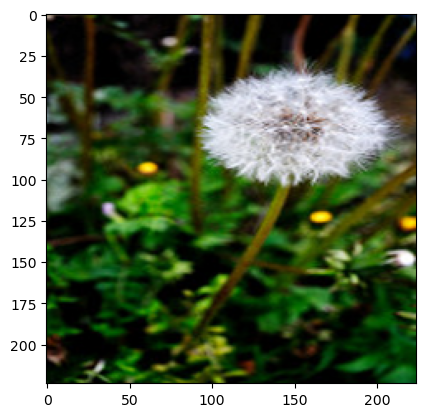

dandelion 1


In [9]:
# Check random image and its label
plt.imshow(X_train[1200])
plt.show()
print(Y_train_classes[1200], end=' ')
print(Y_train[1200])

In [10]:
# Normalising the X_train data batchwise

batch_size = 100  # Define the batch size
X_train = X_train.astype('float32')  # Convert the data to float32 type

num_samples = X_train.shape[0]  # Get the total number of samples
num_batches = num_samples // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size
    
    # Normalise and update X_train with the processed batch
    X_train[start_idx:end_idx] = (X_train[start_idx:end_idx]) / 255.0

if num_samples % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = num_samples
    
    # Normalise and update X_train with the processed batch
    X_train[start_idx:end_idx] = (X_train[start_idx:end_idx]) / 255.0

In [11]:
print(X_train)

[[[[0.8352941  0.84705883 0.8784314 ]
   [0.8117647  0.8352941  0.85882354]
   [0.8156863  0.8235294  0.85490197]
   ...
   [0.02352941 0.02745098 0.04313726]
   [0.03529412 0.03137255 0.04705882]
   [0.02745098 0.02745098 0.04705882]]

  [[0.84313726 0.8627451  0.89411765]
   [0.85882354 0.8745098  0.9019608 ]
   [0.8509804  0.84705883 0.8784314 ]
   ...
   [0.04313726 0.04705882 0.0627451 ]
   [0.05882353 0.05098039 0.07058824]
   [0.03137255 0.03529412 0.05098039]]

  [[0.85490197 0.8627451  0.8901961 ]
   [0.8509804  0.8509804  0.88235295]
   [0.8745098  0.8862745  0.9137255 ]
   ...
   [0.02745098 0.02352941 0.04313726]
   [0.01176471 0.01568628 0.03529412]
   [0.02745098 0.03137255 0.04705882]]

  ...

  [[0.7921569  0.8156863  0.83137256]
   [0.8156863  0.8352941  0.8509804 ]
   [0.85882354 0.8901961  0.9019608 ]
   ...
   [0.6901961  0.65882355 0.60784316]
   [0.7254902  0.6862745  0.6509804 ]
   [0.69411767 0.6509804  0.6313726 ]]

  [[0.8784314  0.89411765 0.9098039 ]
   [0.8

In [12]:
# Creating validation data as a numpy array

X_test_daisy = np.array([cv.imread('flowers/test_set/daisy/'+i) for i in os.listdir('flowers/test_set/daisy')])

X_test_dandelion = np.array([cv.imread('flowers/test_set/dandelion/'+i) for i in os.listdir('flowers/test_set/dandelion')])

X_test_rose = np.array([cv.imread('flowers/test_set/rose/'+i) for i in os.listdir('flowers/test_set/rose')])

X_test_sunflower = np.array([cv.imread('flowers/test_set/sunflower/'+i) for i in os.listdir('flowers/test_set/sunflower')])

X_test_tulip = np.array([cv.imread('flowers/test_set/tulip/'+i) for i in os.listdir('flowers/test_set/tulip')])

# Combining all the validation data
X_test = np.concatenate((X_test_daisy, X_test_dandelion, X_test_rose, X_test_sunflower, X_test_tulip), axis=0)

# Converting BGR to RGB for all the images in X_test
X_test = np.array([cv.cvtColor(i, cv.COLOR_BGR2RGB) for i in X_test])

# Resizing the images in X_test to 224x224
X_test = np.array([cv.resize(i, (224, 224), interpolation=cv.INTER_CUBIC) for i in X_test])

print(X_test.shape)

(701, 224, 224, 3)


In [13]:
# Creating target labels for validation data
Y_test_daisy = np.array(['daisy' for i in range(len(X_test_daisy))])
Y_test_dandelion = np.array(['dandelion' for i in range(len(X_test_dandelion))])
Y_test_rose = np.array(['rose' for i in range(len(X_test_rose))])
Y_test_sunflower = np.array(['sunflower' for i in range(len(X_test_sunflower))])
Y_test_tulip = np.array(['tulip' for i in range(len(X_test_tulip))])

# Combining all the target labels
Y_test_classes = np.concatenate((Y_test_daisy, Y_test_dandelion, Y_test_rose, Y_test_sunflower, Y_test_tulip), axis=0)
print(Y_test_classes.shape)

# Encoding target labels
Y_test = encoder.transform(Y_test_classes)
print(Y_test.shape)

(701,)
(701,)


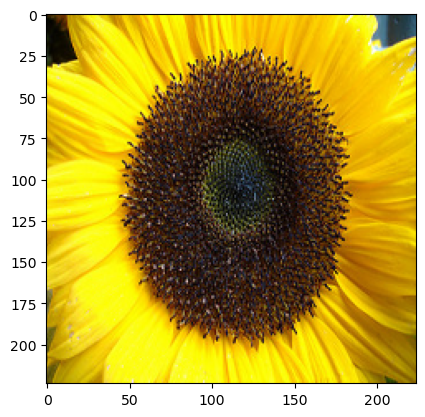

sunflower 3


In [14]:
# Check random image and its label

plt.imshow(X_test[510])
plt.show()
print(Y_test_classes[510], end=' ')
print(Y_test[510])

In [15]:
# Normalising the X_test data batchwise

X_test = X_test.astype('float32')  # Convert the data to float32 type

num_samples = X_test.shape[0]  # Get the total number of samples
num_batches = num_samples // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size
    
    # Normalise and update X_test with the processed batch
    X_test[start_idx:end_idx] = (X_test[start_idx:end_idx]) / 255.0

if num_samples % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = num_samples
    
    # Normalise and update X_test with the processed batch
    X_test[start_idx:end_idx] = (X_test[start_idx:end_idx]) / 255.0

In [16]:
print(X_test)

[[[[0.5294118  0.5294118  0.52156866]
   [0.54901963 0.54901963 0.54901963]
   [0.5686275  0.5686275  0.5686275 ]
   ...
   [0.6039216  0.6039216  0.59607846]
   [0.6039216  0.6039216  0.60784316]
   [0.5882353  0.5882353  0.5882353 ]]

  [[0.5254902  0.5254902  0.5176471 ]
   [0.54509807 0.54509807 0.5372549 ]
   [0.5647059  0.5647059  0.5647059 ]
   ...
   [0.6039216  0.6039216  0.59607846]
   [0.6039216  0.6039216  0.60784316]
   [0.58431375 0.58431375 0.58431375]]

  [[0.52156866 0.52156866 0.5137255 ]
   [0.54509807 0.54509807 0.5372549 ]
   [0.5647059  0.5647059  0.56078434]
   ...
   [0.6        0.6        0.5921569 ]
   [0.6        0.6        0.6039216 ]
   [0.5764706  0.5764706  0.5764706 ]]

  ...

  [[0.1764706  0.1882353  0.10588235]
   [0.17254902 0.18431373 0.10196079]
   [0.17254902 0.18431373 0.10196079]
   ...
   [0.50980395 0.49411765 0.49019608]
   [0.50980395 0.49411765 0.49019608]
   [0.5058824  0.49019608 0.4862745 ]]

  [[0.17254902 0.18431373 0.10196079]
   [0.1

In [17]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(3614, 224, 224, 3) (3614,) (701, 224, 224, 3) (701,)


In [18]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224, 224, 3), trainable=False)

classes = 5

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(classes),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [20]:
model.fit(x=X_train, y=Y_train, batch_size=100, epochs=5)

Epoch 1/5
37/37 [==============================] - 158s 3s/step - loss: 0.9583 - acc: 0.6395
Epoch 2/5
37/37 [==============================] - 150s 4s/step - loss: 0.4926 - acc: 0.8273
Epoch 3/5
37/37 [==============================] - 152s 4s/step - loss: 0.3913 - acc: 0.8700
Epoch 4/5
37/37 [==============================] - 144s 4s/step - loss: 0.3383 - acc: 0.8929
Epoch 5/5
37/37 [==============================] - 134s 4s/step - loss: 0.3059 - acc: 0.8998


In [21]:
score, acc = model.evaluate(x=X_test, y=Y_test)
print('Test accuracy:', acc)

22/22 [==============================] - 51s 941ms/step - loss: 0.2914 - acc: 0.9130
Test accuracy: 0.9129814505577087


### Predictive system

In [25]:
def predict():
    path = input('Enter the path of the image: ')
    image = cv.imread(path)

    try:
        plt.imshow(image)
    except:
        from google.colab.patches import cv2_imshow
        cv2_imshow(image)

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224), interpolation=cv.INTER_CUBIC)
    image = image.astype('float32')
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    prediction = np.argmax(prediction)    
    label = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}
    print(label[prediction])

1/1 [==============================] - 0s 315ms/step
tulip


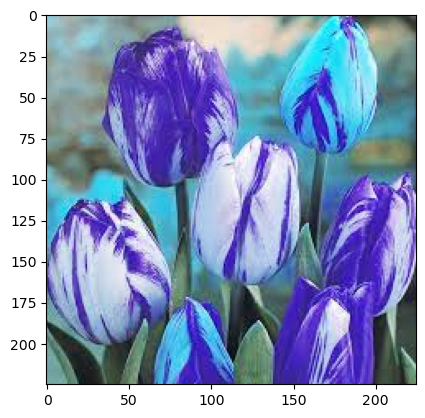

In [26]:
predict()

### Results:
#### Model (Training) Accuracy: 90.87 %
#### Model (Test) Accuracy: 90.72 %

#### Random tests:
<p>random_test_1.jpg: failed
<p>random_test_2.jpg: passed
<p>random_test_3.jpg: passed